# Position and Orientation Estimation for Multiple Cars in a Single Image 
David Besson - https://github.com/dhbesson/Springboard

## Background

This project is based on a Kaggle competion from Peking University called "Can you predict vehicle angle in different settings?" https://www.kaggle.com/c/pku-autonomous-driving

The competion is built on the following paper and dataset:

ApolloCar3D: A Large 3D Car Instance Understanding Benchmark for Autonomous Driving
@inproceedings{song2019apollocar3d,
title={Apollocar3d: A large 3d car instance understanding benchmark for autonomous driving},
author={Song, Xibin and Wang, Peng and Zhou, Dingfu and Zhu, Rui and Guan, Chenye and Dai, Yuchao and Su, Hao and Li, Hongdong and Yang, Ruigang},
booktitle={Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition},
pages={5452--5462},
year={2019}
}

My machine learning framework follows the solution proposed by Kaggle user Ruslan Baynazarov as described in his notebook "CenterNet Baseline." https://www.kaggle.com/hocop1/centernet-baseline/output?scriptVersionId=23634825

## Objective

The goal as stated in the Kaggle competition is to "develop an algorithm to estimate the absolute pose of vehicles (6 degrees of freedom) from a single image in a real-world traffic environment." 

This means that the machine learning framework must detect an arbitrary number of cars in a single static image and return the (x,y,z) position and (roll, pitch, yaw) orientation of each car relative to the camera.


## Training Data

### Images

The training dataset provided by the competition contains 4,262 images. An example image is shown below: (TODO: add info on test set)

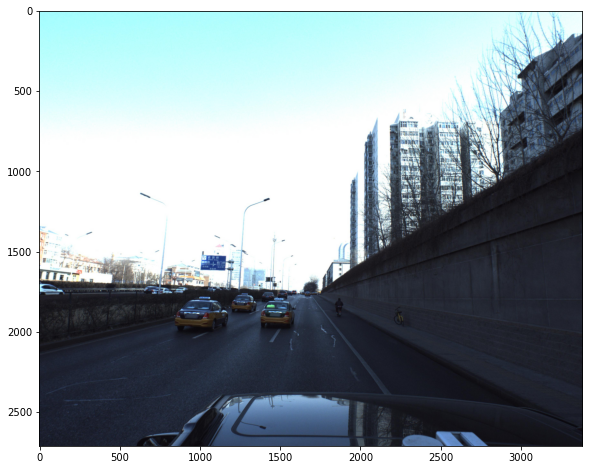

In [1]:
PATH = '../Data Collection/'
import cv2
import matplotlib.pyplot as plt
import numpy as np

def imread(path, fast_mode=False):
    img = cv2.imread(path)
    if not fast_mode and img is not None and len(img.shape) == 3:
        img = np.array(img[:, :, ::-1])
    return img

img = imread(PATH + 'train_images/ID_0a1cb53b1.jpg')
IMG_SHAPE = img.shape

plt.figure(figsize=(15,8))
plt.imshow(img);

In [2]:
IMG_SHAPE

(2710, 3384, 3)

### Labels

Each training image has an associated row in 'train.csv'. The row corresponding to the image above is:

In [3]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

train_raw_df = pd.read_csv('../Data Collection/train.csv')
test_raw_df = pd.read_csv('../Data Collection/sample_submission.csv')

example_df = train_raw_df.loc[train_raw_df['ImageId'] == 'ID_0a1cb53b1']
example_df

,ImageId,PredictionString
1915,ID_0a1cb53b1,28 0.140419 -0.0224375 -3.07343 -5.83187 4.71606 20.5524 70 0.146415 -0.0876996 -3.06955 -2.18146 6.14408 27.1262 54 0.17841 -0.0770509 -3.1197 -7.13103 8.34121 41.229 37 0.140862 0.0259892 -3.09501 -24.1061 10.3933 60.3847 16 0.146415 0.0464519 -3.06955 -6.77555 10.9816 59.745 16 0.146415 0.0926257 -3.06955 -5.45868 12.8078 72.3822 46 0.140862 -0.437937 -3.09502 -36.4212 8.67895 51.47 16 0.140862 -0.0871665 -3.09501 -31.3829 12.4759 74.7823 16 0.140861 -0.0180298 -3.09502 -26.3444 12.8741 76.5597


The 'Prediction String' column contains a concatenated set of label lists for each car in the image. The label list structure is:

\[3D_model_id, yaw, pitch, roll, x, y, z\]

'3D_model_id' is the corresponding 3D model of the car as provided by the competition creators. These models are not used in this machine learning framework, but are useful for visualizing predictions.

### Coordinate System

The camera coordinate system is (PUT IN A BETTER FIGURE):

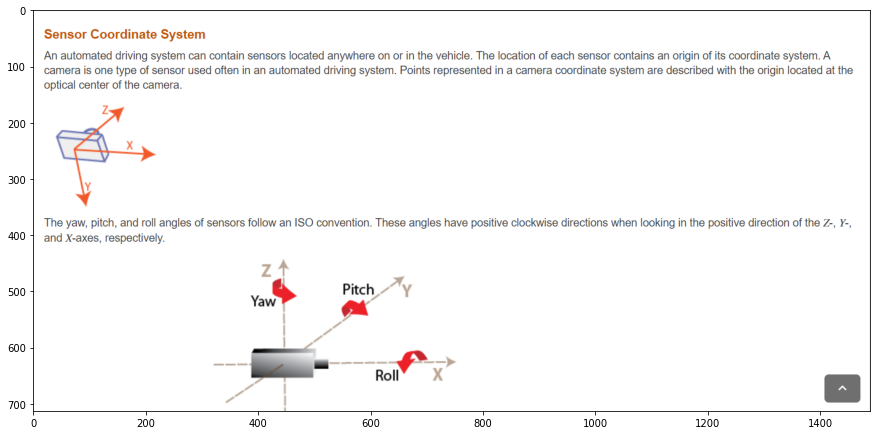

In [4]:
img = imread(PATH + 'camera/Sensor_Coordinate_System.png')
plt.figure(figsize=(15,8))
plt.imshow(img)

### Training Labels

The following function parses the 'PredictionString' and returns a list of the label dicts for each car in a training image.

In [5]:
def str2coords(s, names=['id', 'yaw', 'pitch', 'roll', 'x', 'y', 'z']):
    '''
    Input:
        s: PredictionString (e.g. from train dataframe)
        names: array of what to extract from the string
    Output:
        list of dicts with keys from `names`
    '''
    coords = []
    for l in np.array(s.split()).reshape([-1, 7]):
        coords.append(dict(zip(names, l.astype('float'))))
        if 'id' in coords[-1]:
            coords[-1]['id'] = int(coords[-1]['id'])
    return coords

This function can be used to create a dataframe of the cars in the example image used above.

In [6]:
example_points_df = pd.DataFrame()
for col in ['x', 'y', 'z', 'yaw', 'pitch', 'roll']:
    arr = []
    for ps in example_df['PredictionString']:
        coords = str2coords(ps)
        arr += [c[col] for c in coords]
    example_points_df[col] = arr
    
example_points_df

,x,y,z,yaw,pitch,roll
0,-5.83187,4.71606,20.5524,0.140419,-0.022437,-3.07343
1,-2.18146,6.14408,27.1262,0.146415,-0.087700,-3.06955
2,-7.13103,8.34121,41.2290,0.178410,-0.077051,-3.11970
3,-24.10610,10.39330,60.3847,0.140862,0.025989,-3.09501
4,-6.77555,10.98160,59.7450,0.146415,0.046452,-3.06955
5,-5.45868,12.80780,72.3822,0.146415,0.092626,-3.06955
6,-36.42120,8.67895,51.4700,0.140862,-0.437937,-3.09502
7,-31.38290,12.47590,74.7823,0.140862,-0.087166,-3.09501
8,-26.34440,12.87410,76.5597,0.140861,-0.018030,-3.09502


In [7]:
import pickle
from sklearn.linear_model import LinearRegression

points_df = pd.DataFrame()
for col in ['x', 'y', 'z', 'yaw', 'pitch', 'roll']:
    arr = []
    for ps in train_raw_df['PredictionString']:
        coords = str2coords(ps)
        arr += [c[col] for c in coords]
    points_df[col] = arr
    
xzy_slope = LinearRegression()
X = points_df[['x', 'z']]
y = points_df['y']
xzy_slope.fit(X, y)

pickle.dump( xzy_slope, open("../Data Wrangling/xzy_slope.p", "wb" ) )

### 2D and Camera Projections

The points projected in the X-Y plane as seen looking in the +Z direction is: (TODO: add labels for points)

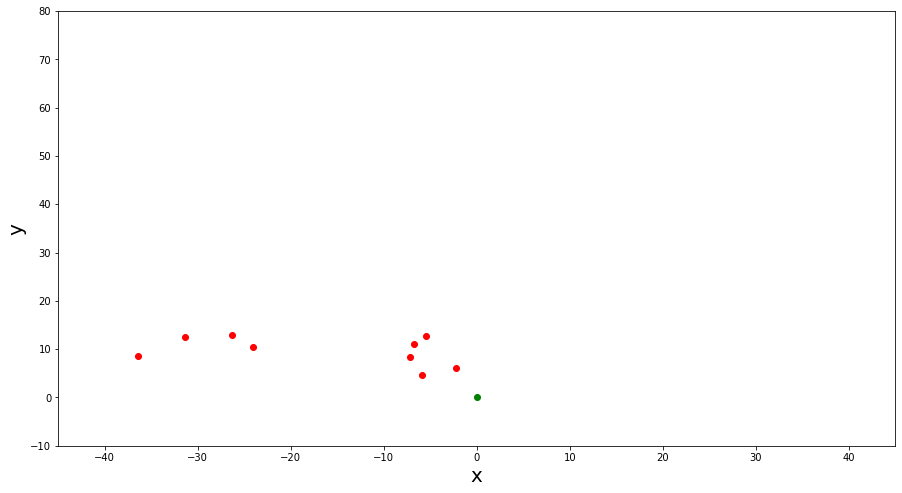

In [8]:
fig = plt.figure(figsize=(15,8))
plt.scatter(example_points_df['x'], example_points_df['y'],c='red')
plt.scatter(0, 0,c='green')
ax = fig.gca()
ax.set_xlabel('x', fontsize=20)
ax.set_ylabel('y', fontsize=20)
ax.set_xlim(-45,45)
ax.set_ylim(-10,80)

plt.show()

And the top-down view of the X-Z plane is:

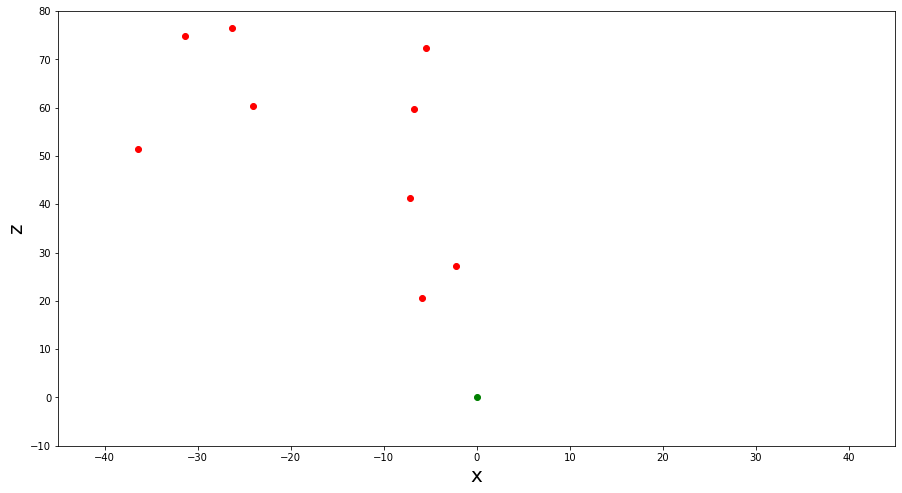

In [9]:
fig = plt.figure(figsize=(15,8))
plt.scatter(example_points_df['x'], example_points_df['z'],c='red')
plt.scatter(0, 0,c='green')
ax = fig.gca()
ax.set_xlabel('x', fontsize=20)
ax.set_ylabel('z', fontsize=20)
ax.set_xlim(-45,45)
ax.set_ylim(-10,80)

plt.show()

A matrix transfomration allows the points to be plotted in the 2D perspective as seen from the camera.

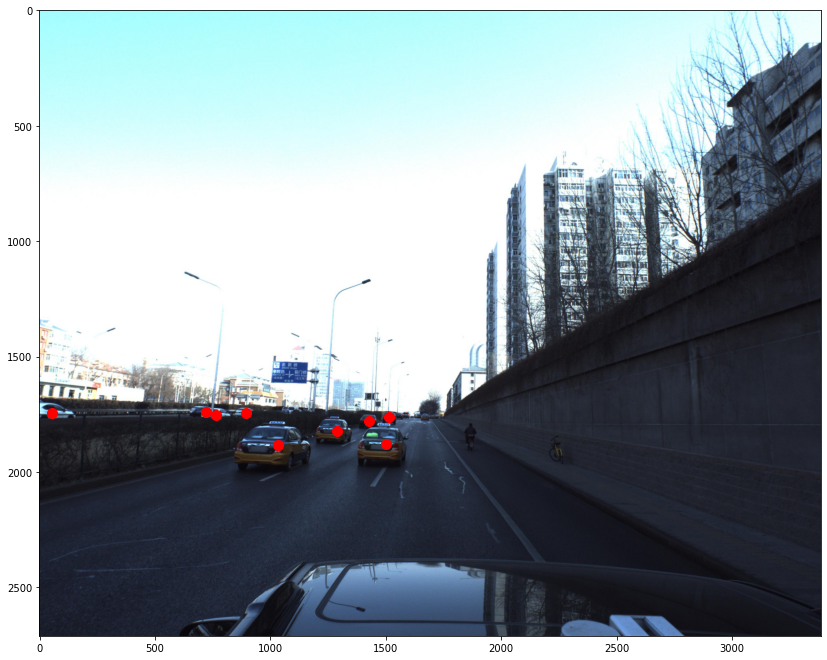

In [10]:
camera_matrix = np.array([[2304.5479, 0,  1686.2379],
                          [0, 2305.8757, 1354.9849],
                          [0, 0, 1]], dtype=np.float32)

def get_img_coords(s):
    '''
    Input is a PredictionString (e.g. from train dataframe)
    Output is two arrays:
        xs: x coordinates in the image (row)
        ys: y coordinates in the image (column)
    '''
    coords = str2coords(s)
    xs = [c['x'] for c in coords]
    ys = [c['y'] for c in coords]
    zs = [c['z'] for c in coords]
    P = np.array(list(zip(xs, ys, zs))).T
    img_p = np.dot(camera_matrix, P).T
    img_p[:, 0] /= img_p[:, 2]
    img_p[:, 1] /= img_p[:, 2]
    img_xs = img_p[:, 0]
    img_ys = img_p[:, 1]
    img_zs = img_p[:, 2] # z = Distance from the camera
    return img_xs, img_ys

plt.figure(figsize=(14,14))
plt.imshow(imread(PATH + 'train_images/' + 'ID_0a1cb53b1.jpg'))
plt.scatter(*get_img_coords(example_df['PredictionString'][1915]), color='red', s=100)
plt.show()

### Visualizing Orientation

The orientation of the cars can be plotted by including some additional transformation functions.

In [11]:
from math import sin, cos

# convert euler angle to rotation matrix
def euler_to_Rot(yaw, pitch, roll):
    Y = np.array([[cos(yaw), 0, sin(yaw)],
                  [0, 1, 0],
                  [-sin(yaw), 0, cos(yaw)]])
    P = np.array([[1, 0, 0],
                  [0, cos(pitch), -sin(pitch)],
                  [0, sin(pitch), cos(pitch)]])
    R = np.array([[cos(roll), -sin(roll), 0],
                  [sin(roll), cos(roll), 0],
                  [0, 0, 1]])
    return np.dot(Y, np.dot(P, R))

In [12]:
def draw_line(image, points):
    color = (255, 0, 0)
    cv2.line(image, tuple(points[0][:2]), tuple(points[3][:2]), color, 16)
    cv2.line(image, tuple(points[0][:2]), tuple(points[1][:2]), color, 16)
    cv2.line(image, tuple(points[1][:2]), tuple(points[2][:2]), color, 16)
    cv2.line(image, tuple(points[2][:2]), tuple(points[3][:2]), color, 16)
    return image


def draw_points(image, points):
    for (p_x, p_y, p_z) in points:
        cv2.circle(image, (p_x, p_y), int(1000 / p_z), (0, 255, 0), -1)
#         if p_x > image.shape[1] or p_y > image.shape[0]:
#             print('Point', p_x, p_y, 'is out of image with shape', image.shape)
    return image

In [13]:
def visualize(img, coords):
    # You will also need functions from the previous cells
    x_l = 1.02
    y_l = 0.80
    z_l = 2.31
    
    img = img.copy()
    for point in coords:
        # Get values
        x, y, z = point['x'], point['y'], point['z']
        yaw, pitch, roll = -point['pitch'], -point['yaw'], -point['roll']
        # Math
        Rt = np.eye(4)
        t = np.array([x, y, z])
        Rt[:3, 3] = t
        Rt[:3, :3] = euler_to_Rot(yaw, pitch, roll).T
        Rt = Rt[:3, :]
        P = np.array([[x_l, -y_l, -z_l, 1],
                      [x_l, -y_l, z_l, 1],
                      [-x_l, -y_l, z_l, 1],
                      [-x_l, -y_l, -z_l, 1],
                      [0, 0, 0, 1]]).T
        img_cor_points = np.dot(camera_matrix, np.dot(Rt, P))
        img_cor_points = img_cor_points.T
        img_cor_points[:, 0] /= img_cor_points[:, 2]
        img_cor_points[:, 1] /= img_cor_points[:, 2]
        img_cor_points = img_cor_points.astype(int)
        # Drawing
        img = draw_line(img, img_cor_points)
        img = draw_points(img, img_cor_points[-1:])
    
    return img

Using these functions on the image and training labels used above shows:

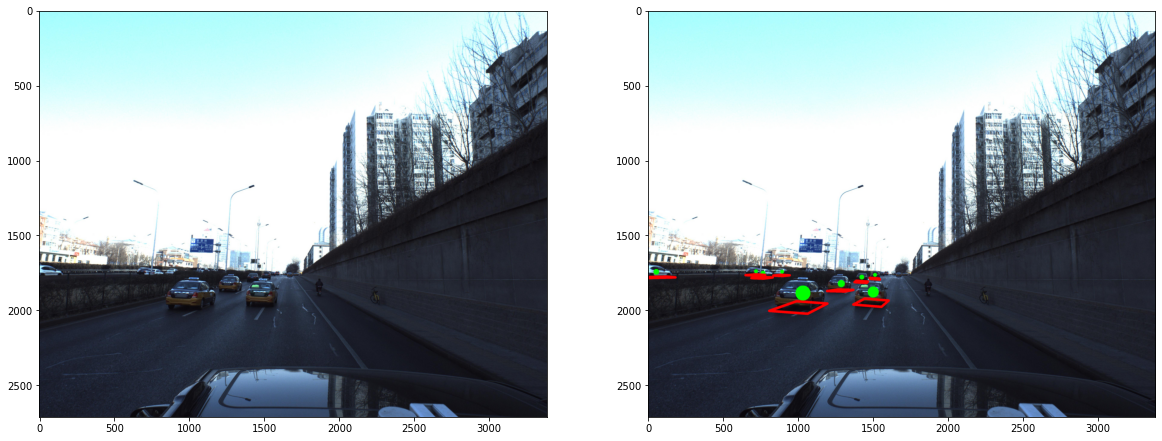

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(20,20))
img = imread(PATH + 'train_images/ID_0a1cb53b1.jpg')
axes[0].imshow(img)
img_vis = visualize(img, str2coords(example_df['PredictionString'][1915]))
axes[1].imshow(img_vis)
plt.show()

### Image Preprocessing

A series of preprocessing steps are used to simplify and improve the training process.

In [15]:
IMG_WIDTH = 1024
IMG_HEIGHT = IMG_WIDTH // 16 * 5
MODEL_SCALE = 8

def rotate(x, angle):
    x = x + angle
    x = x - (x + np.pi) // (2 * np.pi) * 2 * np.pi
    return x

def _regr_preprocess(regr_dict, flip=False):
    if flip:
        for k in ['x', 'pitch', 'roll']:
            regr_dict[k] = -regr_dict[k]
    for name in ['x', 'y', 'z']:
        regr_dict[name] = regr_dict[name] / 100
    regr_dict['roll'] = rotate(regr_dict['roll'], np.pi)
    regr_dict['pitch_sin'] = sin(regr_dict['pitch'])
    regr_dict['pitch_cos'] = cos(regr_dict['pitch'])
    regr_dict.pop('pitch')
    regr_dict.pop('id')
    return regr_dict

def _regr_back(regr_dict):
    for name in ['x', 'y', 'z']:
        regr_dict[name] = regr_dict[name] * 100
    regr_dict['roll'] = rotate(regr_dict['roll'], -np.pi)
    
    pitch_sin = regr_dict['pitch_sin'] / np.sqrt(regr_dict['pitch_sin']**2 + regr_dict['pitch_cos']**2)
    pitch_cos = regr_dict['pitch_cos'] / np.sqrt(regr_dict['pitch_sin']**2 + regr_dict['pitch_cos']**2)
    regr_dict['pitch'] = np.arccos(pitch_cos) * np.sign(pitch_sin)
    return regr_dict

def preprocess_image(img, flip=False):
    img = img[img.shape[0] // 2:]
    bg = np.ones_like(img) * img.mean(1, keepdims=True).astype(img.dtype)
    bg = bg[:, :img.shape[1] // 6]
    img = np.concatenate([bg, img, bg], 1)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    if flip:
        img = img[:,::-1]
    return (img / 255).astype('float32')

def get_mask_and_regr(img, labels, flip=False):
    mask = np.zeros([IMG_HEIGHT // MODEL_SCALE, IMG_WIDTH // MODEL_SCALE], dtype='float32')
    regr_names = ['x', 'y', 'z', 'yaw', 'pitch', 'roll']
    regr = np.zeros([IMG_HEIGHT // MODEL_SCALE, IMG_WIDTH // MODEL_SCALE, 7], dtype='float32')
    coords = str2coords(labels)
    xs, ys = get_img_coords(labels)
    for x, y, regr_dict in zip(xs, ys, coords):
        x, y = y, x
        x = (x - img.shape[0] // 2) * IMG_HEIGHT / (img.shape[0] // 2) / MODEL_SCALE
        x = np.round(x).astype('int')
        y = (y + img.shape[1] // 6) * IMG_WIDTH / (img.shape[1] * 4/3) / MODEL_SCALE
        y = np.round(y).astype('int')
        if x >= 0 and x < IMG_HEIGHT // MODEL_SCALE and y >= 0 and y < IMG_WIDTH // MODEL_SCALE:
            mask[x, y] = 1
            regr_dict = _regr_preprocess(regr_dict, flip)
            regr[x, y] = [regr_dict[n] for n in sorted(regr_dict)]
    if flip:
        mask = np.array(mask[:,::-1])
        regr = np.array(regr[:,::-1])
    return mask, regr

img.shape (320, 1024, 3) std: 0.26779675
mask.shape (40, 128) std: 0.04188941
regr.shape (40, 128, 7) std: 0.018770438


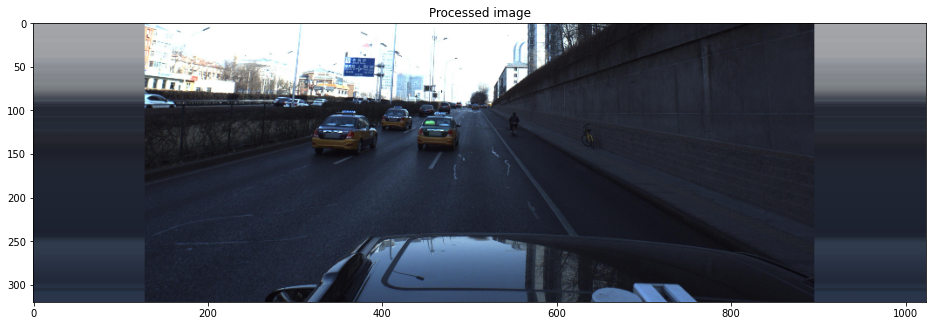

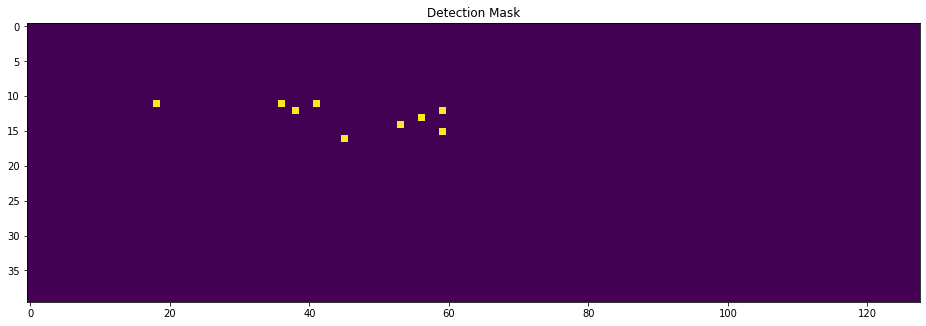

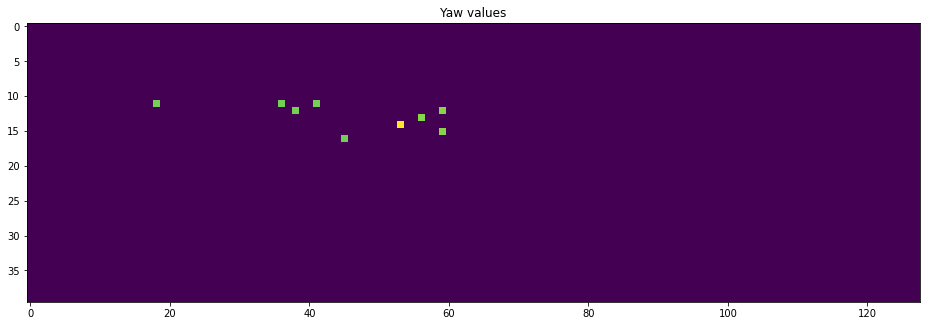

In [16]:
img0 = imread(PATH + 'train_images/ID_0a1cb53b1.jpg')
img = preprocess_image(img0)

mask, regr = get_mask_and_regr(img0, example_df['PredictionString'][1915])

print('img.shape', img.shape, 'std:', np.std(img))
print('mask.shape', mask.shape, 'std:', np.std(mask))
print('regr.shape', regr.shape, 'std:', np.std(regr))

plt.figure(figsize=(16,16))
plt.title('Processed image')
plt.imshow(img)
plt.show()

plt.figure(figsize=(16,16))
plt.title('Detection Mask')
plt.imshow(mask)
plt.show()

plt.figure(figsize=(16,16))
plt.title('Yaw values')
plt.imshow(regr[:,:,-2])
plt.show()

A separate set of functions are used to convert these 2D maps back to the \[x, y, z, roll, pitch, yaw\] label structure. (TODO: show more examples of intermediate steps)

In [17]:
DISTANCE_THRESH_CLEAR = 2

def convert_3d_to_2d(x, y, z, fx = 2304.5479, fy = 2305.8757, cx = 1686.2379, cy = 1354.9849):
    # stolen from https://www.kaggle.com/theshockwaverider/eda-visualization-baseline
    return x * fx / z + cx, y * fy / z + cy

def optimize_xy(r, c, x0, y0, z0, flipped=False):
    def distance_fn(xyz):
        x, y, z = xyz
        xx = -x if flipped else x
        slope_err = (xzy_slope.predict([[xx,z]])[0] - y)**2
        x, y = convert_3d_to_2d(x, y, z)
        y, x = x, y
        x = (x - IMG_SHAPE[0] // 2) * IMG_HEIGHT / (IMG_SHAPE[0] // 2) / MODEL_SCALE
        y = (y + IMG_SHAPE[1] // 6) * IMG_WIDTH / (IMG_SHAPE[1] * 4 / 3) / MODEL_SCALE
        return max(0.2, (x-r)**2 + (y-c)**2) + max(0.4, slope_err)
    
    res = minimize(distance_fn, [x0, y0, z0], method='Powell')
    x_new, y_new, z_new = res.x
    return x_new, y_new, z_new

def clear_duplicates(coords):
    for c1 in coords:
        xyz1 = np.array([c1['x'], c1['y'], c1['z']])
        for c2 in coords:
            xyz2 = np.array([c2['x'], c2['y'], c2['z']])
            distance = np.sqrt(((xyz1 - xyz2)**2).sum())
            if distance < DISTANCE_THRESH_CLEAR:
                if c1['confidence'] < c2['confidence']:
                    c1['confidence'] = -1
    return [c for c in coords if c['confidence'] > 0]

def extract_coords(prediction, flipped=False):
    logits = prediction[0]
    regr_output = prediction[1:]
    points = np.argwhere(logits > 0)
    col_names = sorted(['x', 'y', 'z', 'yaw', 'pitch_sin', 'pitch_cos', 'roll'])
    coords = []
    for r, c in points:
        regr_dict = dict(zip(col_names, regr_output[:, r, c]))
        coords.append(_regr_back(regr_dict))
        coords[-1]['confidence'] = 1 / (1 + np.exp(-logits[r, c]))
        coords[-1]['x'], coords[-1]['y'], coords[-1]['z'] = \
                optimize_xy(r, c,
                            coords[-1]['x'],
                            coords[-1]['y'],
                            coords[-1]['z'], flipped)
    coords = clear_duplicates(coords)
    return coords

def coords2str(coords, names=['yaw', 'pitch', 'roll', 'x', 'y', 'z', 'confidence']):
    s = []
    for c in coords:
        for n in names:
            s.append(str(c.get(n, 0)))
    return ' '.join(s)

The final step is to create a class that can be used to organize the image and label data for the training and test sets.

In [18]:
from torch.utils.data import Dataset

class CarDataset(Dataset):
    """Car dataset."""

    def __init__(self, dataframe, root_dir, training=True, transform=None):
        self.df = dataframe
        self.root_dir = root_dir
        self.transform = transform
        self.training = training

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Get image name
        idx, labels = self.df.values[idx]
        img_name = self.root_dir.format(idx)
        
        # Augmentation
        flip = False
        if self.training:
            flip = np.random.randint(10) == 1
        
        # Read image
        img0 = imread(img_name, True)
        img = preprocess_image(img0, flip=flip)
        img = np.rollaxis(img, 2, 0)
        
        # Get mask and regression maps
        mask, regr = get_mask_and_regr(img0, labels, flip=flip)
        regr = np.rollaxis(regr, 2, 0)
        
        return [img, mask, regr]

In [19]:
from sklearn.model_selection import train_test_split

train_images_dir = PATH + 'train_images/{}.jpg'
test_images_dir = PATH + 'test_images/{}.jpg'

df_train, df_dev = train_test_split(train_raw_df, test_size=0.01, random_state=42)
df_test = test_raw_df

# Create dataset objects
train_dataset = CarDataset(df_train, train_images_dir, training=True)
dev_dataset = CarDataset(df_dev, train_images_dir, training=False)
test_dataset = CarDataset(df_test, test_images_dir, training=False)

These datasets will be used to train the machine learning model.

In [20]:
import pickle

pickle.dump( train_dataset, open("../Data Wrangling/datasets/train_dataset.p", "wb" ) )
pickle.dump( dev_dataset, open("../Data Wrangling/datasets/dev_dataset.p", "wb" ) )
pickle.dump( test_dataset, open("../Data Wrangling/datasets/test_dataset.p", "wb" ) )

In [21]:
from torch.utils.data import DataLoader

BATCH_SIZE = 4

# Create data generators - they will produce batches
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
dev_loader = DataLoader(dataset=dev_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [22]:
from efficientnet_pytorch import EfficientNet

In [23]:
import torch.nn as nn

class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2=None):
        x1 = self.up(x1)
        
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        
        # for padding issues, see 
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        
        if x2 is not None:
            x = torch.cat([x2, x1], dim=1)
        else:
            x = x1
        x = self.conv(x)
        return x

def get_mesh(batch_size, shape_x, shape_y):
    mg_x, mg_y = np.meshgrid(np.linspace(0, 1, shape_y), np.linspace(0, 1, shape_x))
    mg_x = np.tile(mg_x[None, None, :, :], [batch_size, 1, 1, 1]).astype('float32')
    mg_y = np.tile(mg_y[None, None, :, :], [batch_size, 1, 1, 1]).astype('float32')
    mesh = torch.cat([torch.tensor(mg_x).to(device), torch.tensor(mg_y).to(device)], 1)
    return mesh

In [24]:
class MyUNet(nn.Module):
    '''Mixture of previous classes'''
    def __init__(self, n_classes):
        super(MyUNet, self).__init__()
        self.base_model = EfficientNet.from_pretrained('efficientnet-b0')
        
        self.conv0 = double_conv(5, 64)
        self.conv1 = double_conv(64, 128)
        self.conv2 = double_conv(128, 512)
        self.conv3 = double_conv(512, 1024)
        
        self.mp = nn.MaxPool2d(2)
        
        self.up1 = up(1282 + 1024, 512)
        self.up2 = up(512 + 512, 256)
        self.outc = nn.Conv2d(256, n_classes, 1)

    def forward(self, x):
        batch_size = x.shape[0]
        mesh1 = get_mesh(batch_size, x.shape[2], x.shape[3])
        x0 = torch.cat([x, mesh1], 1)
        x1 = self.mp(self.conv0(x0))
        x2 = self.mp(self.conv1(x1))
        x3 = self.mp(self.conv2(x2))
        x4 = self.mp(self.conv3(x3))
        
        x_center = x[:, :, :, IMG_WIDTH // 8: -IMG_WIDTH // 8]
        feats = self.base_model.extract_features(x_center)
        bg = torch.zeros([feats.shape[0], feats.shape[1], feats.shape[2], feats.shape[3] // 8]).to(device)
        feats = torch.cat([bg, feats, bg], 3)
        
        # Add positional info
        mesh2 = get_mesh(batch_size, feats.shape[2], feats.shape[3])
        feats = torch.cat([feats, mesh2], 1)
        
        x = self.up1(feats, x4)
        x = self.up2(x, x3)
        x = self.outc(x)
        return x

In [26]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler

# Gets the GPU if there is one, otherwise the cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

n_epochs = 10

model = MyUNet(8).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=max(n_epochs, 10) * len(train_loader) // 3, gamma=0.1)

cuda
Loaded pretrained weights for efficientnet-b0


In [27]:
def train_model(epoch, history=None):
    model.train()

    for batch_idx, (img_batch, mask_batch, regr_batch) in enumerate(tqdm(train_loader)):
        img_batch = img_batch.to(device)
        mask_batch = mask_batch.to(device)
        regr_batch = regr_batch.to(device)
        
        optimizer.zero_grad()
        output = model(img_batch)
        loss = criterion(output, mask_batch, regr_batch)
        if history is not None:
            history.loc[epoch + batch_idx / len(train_loader), 'train_loss'] = loss.data.cpu().numpy()
        
        loss.backward()
        
        optimizer.step()
        exp_lr_scheduler.step()
    
    print('Train Epoch: {} \tLR: {:.6f}\tLoss: {:.6f}'.format(
        epoch,
        optimizer.state_dict()['param_groups'][0]['lr'],
        loss.data))

def evaluate_model(epoch, history=None):
    model.eval()
    loss = 0
    
    with torch.no_grad():
        for img_batch, mask_batch, regr_batch in dev_loader:
            img_batch = img_batch.to(device)
            mask_batch = mask_batch.to(device)
            regr_batch = regr_batch.to(device)

            output = model(img_batch)

            loss += criterion(output, mask_batch, regr_batch, size_average=False).data
    
    loss /= len(dev_loader.dataset)
    
    if history is not None:
        history.loc[epoch, 'dev_loss'] = loss.cpu().numpy()
    
    print('Dev loss: {:.4f}'.format(loss))

In [ ]:
%%time
import gc
import pandas as pd
import torch
from tqdm import tqdm

history = pd.DataFrame()

for epoch in range(1):
    torch.cuda.empty_cache()
    gc.collect()
    train_model(epoch, history)
    evaluate_model(epoch, history)

  0%|                                                                                                                                                                           | 0/1055 [00:00<?, ?it/s]